# Threat Zone Prediction Model Training

This notebook demonstrates the training process for our threat prediction models, including the threat detection model, explosion model, and dispersion model.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Add parent directory to path for importing modules
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from models.threat_model import ThreatModel
from models.preprocessing import generate_synthetic_data, SensorDataPreprocessor
from utils.data_processing import split_dataset

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

## Generate and Prepare Training Data

Since we don't have real data yet, we'll generate synthetic data for model development.

In [2]:
# Generate synthetic data
X, y = generate_synthetic_data(n_samples=10000, include_anomalies=True)

# Display data summary
print(f"Total samples: {len(X)}")
print(f"Threat samples: {sum(y)}")
print(f"Safe samples: {len(y) - sum(y)}")
print(f"Threat percentage: {100 * sum(y)/len(y):.2f}%")

# Show feature columns
print("\nFeatures:")
print(X.columns.tolist())

Total samples: 10000
Threat samples: 1000
Safe samples: 9000
Threat percentage: 10.00%

Features:
['mq2', 'mq4', 'mq6', 'mq8', 'temperature', 'humidity']


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create a preprocessor
preprocessor = SensorDataPreprocessor()
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Training set shape: {X_train_processed.shape}")
print(f"Testing set shape: {X_test_processed.shape}")

Training set shape: (8000, 6)
Testing set shape: (2000, 6)


## Threat Detection Model Training

Let's train and evaluate our threat detection model using Random Forest.

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1801
           1       1.00      1.00      1.00       199

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



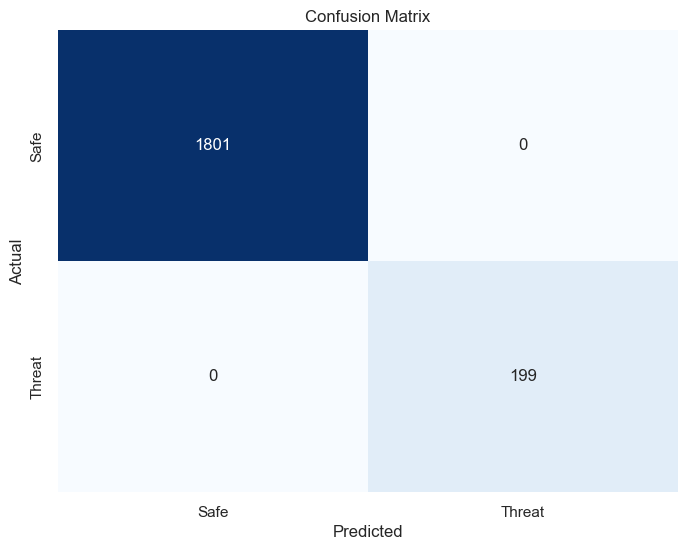

In [4]:
# Create and train the basic model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_processed)
y_prob = rf_model.predict_proba(X_test_processed)[:, 1]  # Probability of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Safe', 'Threat'],
            yticklabels=['Safe', 'Threat'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Feature Importance

Let's examine which features are most important for threat prediction.

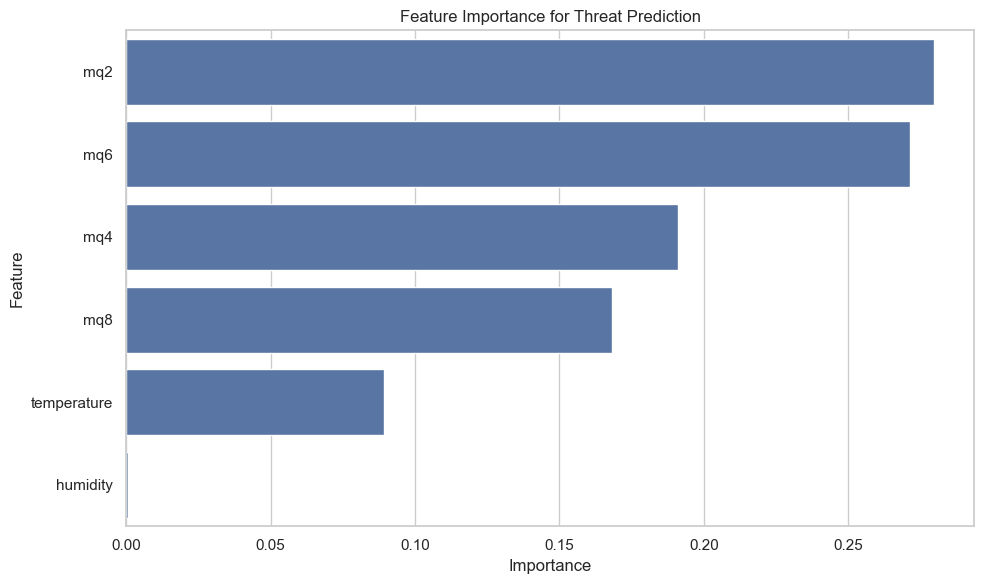

Top features by importance:
       Feature  Importance
0          mq2    0.279493
1          mq6    0.271299
2          mq4    0.190920
3          mq8    0.168324
4  temperature    0.089314
5     humidity    0.000649


In [5]:
# Get feature importances from the model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Threat Prediction')
plt.tight_layout()
plt.show()

# Print the top features
print("Top features by importance:")
print(importance_df)

## Hyperparameter Tuning

Let's optimize our model with cross-validation and grid search.

In [6]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create grid search with cross-validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,  # Use all available cores
    scoring='f1',  # Optimize for F1 score
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_processed, y_train)

# Get the best parameters
print("Best parameters:")
print(grid_search.best_params_)
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Create a model with the best parameters
best_rf_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred_best = best_rf_model.predict(X_test_processed)
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f"\nTuned model metrics on test set:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best F1 score: 1.0000

Tuned model metrics on test set:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


## Compare Different Models

Let's compare Random Forest with Gradient Boosting.

Gradient Boosting metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Model Comparison:
                     Accuracy  Precision  Recall  F1 Score
Random Forest             1.0        1.0     1.0       1.0
Tuned Random Forest       1.0        1.0     1.0       1.0
Gradient Boosting         1.0        1.0     1.0       1.0


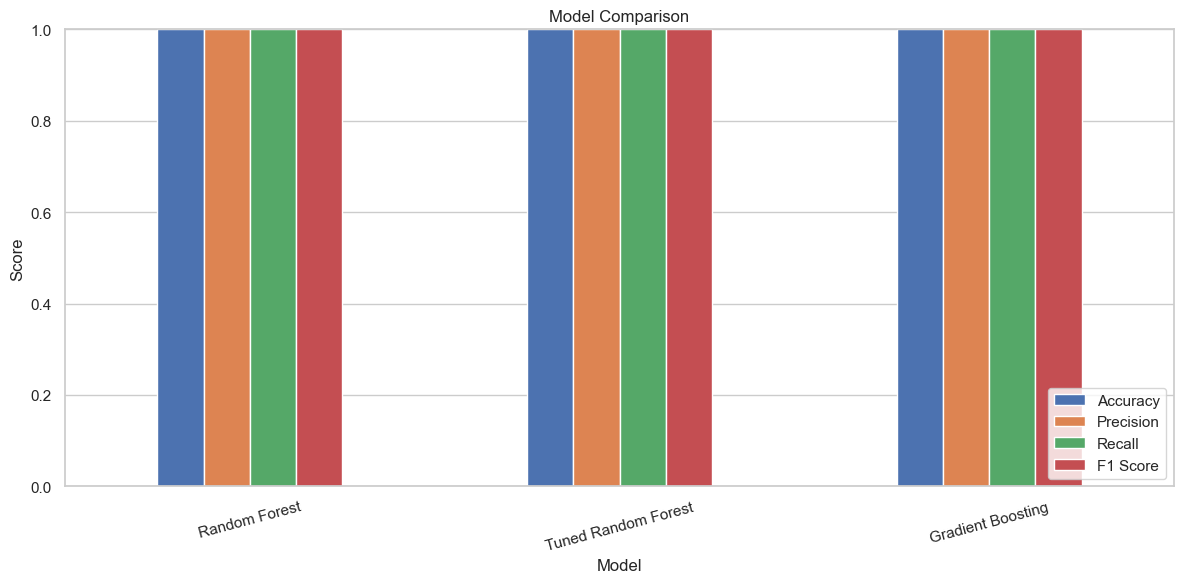

In [7]:
# Create and train Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)
gb_model.fit(X_train_processed, y_train)

# Make predictions with Gradient Boosting
y_pred_gb = gb_model.predict(X_test_processed)

# Calculate metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

print(f"Gradient Boosting metrics:")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1 Score: {f1_gb:.4f}")

# Compare models
models = ['Random Forest', 'Tuned Random Forest', 'Gradient Boosting']
metrics = {
    'Accuracy': [accuracy, accuracy_best, accuracy_gb],
    'Precision': [precision, precision_best, precision_gb],
    'Recall': [recall, recall_best, recall_gb],
    'F1 Score': [f1, f1_best, f1_gb]
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(metrics, index=models)
print("\nModel Comparison:")
print(comparison_df)

# Plot comparison
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Save the Best Model

Let's save our best model for later use.

In [8]:
import joblib

# Create directory if it doesn't exist
os.makedirs('../models/saved', exist_ok=True)

# Save the best model
joblib.dump(best_rf_model, '../models/saved/threat_model.joblib')

# Save the preprocessor
joblib.dump(preprocessor, '../models/saved/preprocessor.joblib')

print("Saved model and preprocessor to '../models/saved/'")

Saved model and preprocessor to '../models/saved/'


## Create and Save Threat Model

Let's use our custom ThreatModel class with the best model.

In [9]:
# Initialize threat model with our trained model
threat_model = ThreatModel('../models/saved/threat_model.joblib')

# Test the threat model with a sample input
sample = X_test.iloc[0]
prediction = threat_model.predict(
    mq2=sample['mq2'],
    mq4=sample['mq4'],
    mq6=sample['mq6'],
    mq8=sample['mq8'],
    temperature=sample['temperature'],
    humidity=sample['humidity']
)

print(f"Sample input: {sample}")
print(f"Actual threat level: {y_test.iloc[0]}")
print(f"Prediction: {prediction}")

Sample input: mq2            500.905247
mq4            220.777540
mq6            483.841525
mq8            231.130315
temperature     37.440533
humidity        71.508494
Name: 6252, dtype: float64
Actual threat level: 0
Prediction: {'risk_score': 1.0, 'risk_level': 'HIGH', 'recommendations': ['Evacuate all personnel immediately', 'Activate emergency response team', 'Notify authorities', 'Implement full shutdown procedures'], 'sensor_status': {'mq2': 'NORMAL', 'mq4': 'NORMAL', 'mq6': 'NORMAL', 'mq8': 'NORMAL', 'temperature': 'NORMAL', 'humidity': 'NORMAL'}}


## Summary

In this notebook, we've:

1. Generated synthetic training data for threat prediction
2. Trained and evaluated a basic Random Forest classifier
3. Analyzed feature importance to understand key predictors
4. Optimized the model with hyperparameter tuning
5. Compared different model types (Random Forest vs. Gradient Boosting)
6. Saved the best model for deployment
7. Created a ThreatModel instance using our trained model

The saved model can now be loaded by our API for making real-time predictions based on sensor data.